### Step 3: Train the Neural Network (Optional)
1. Run all cells to:
      * Load `features_dataset.csv`.
      * Train the neural network for mood clasification.
      * Save outputs:
        * `mood_predicting_model.pth`
        * `label_encoder.pkl`
        * `scaler.pkl`

In [1]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.nn.functional as F
import joblib
import pickle
import os
import matplotlib.pyplot as plt

In [2]:
# Load the features dataset
file_path = './features_dataset.csv'
if not os.path.exists(file_path):
    raise FileNotFoundError(f"{file_path} not found. Ensure the file exists in the correct directory.")

features_df = pd.read_csv(file_path)

In [3]:
# # Validation: Ensure feature columns are consistent
# expected_columns = [
#     'popularity', 'duration_ms', 'danceability', 'energy', 'key',
#     'loudness', 'speechiness', 'acousticness', 'instrumentalness',
#     'liveness', 'valence', 'tempo'
# ]

# missing_columns = set(expected_columns) - set(features_df.columns)
# extra_columns = set(features_df.columns) - set(expected_columns)

# if missing_columns:
#     raise ValueError(f"Missing columns in features_dataset.csv: {missing_columns}")
# if extra_columns:
#     print(f"Warning: Extra columns in features_dataset.csv will be ignored: {extra_columns}")

In [4]:
# Define mood labels
def assign_mood(row):
    if row['valence'] > 0.6 and row['energy'] > 0.7:
        return 'energetic'
    elif row['valence'] < 0.4 and row['energy'] < 0.5:
        return 'sad'
    elif row['valence'] > 0.6:
        return 'happy'
    else:
        return 'calm'

features_df['mood'] = features_df.apply(assign_mood, axis=1)

In [5]:
# Train-test split for raw dataset
train_df, test_df = train_test_split(features_df, test_size=0.2, random_state=42)

In [6]:
# Fit scaler and encoder on training data only
scaler = StandardScaler()
label_encoder = LabelEncoder()

In [7]:
# Preprocess training data
X_train = train_df.drop(columns=['mood', 'mood_encoded'], errors='ignore')
y_train = label_encoder.fit_transform(train_df['mood'])

X_train_scaled = scaler.fit_transform(X_train)

In [8]:
# Save scaler and encoder
joblib.dump(scaler, 'scaler.pkl')
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(label_encoder, f)

In [9]:
# Preprocess test data using the same scaler and encoder
X_test = test_df.drop(columns=['mood', 'mood_encoded'], errors='ignore')
y_test = label_encoder.transform(test_df['mood'])
X_test_scaled = scaler.transform(X_test)

In [10]:
# Further split training data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

In [11]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

In [12]:
# DataLoaders
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
val_loader = DataLoader(TensorDataset(X_val_tensor, y_val_tensor), batch_size=32, shuffle=False)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32, shuffle=False)

In [13]:
# **Step 2: Define the Model**
class MoodPredictorNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MoodPredictorNN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, num_classes)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

input_size = X_train_tensor.shape[1]
num_classes = len(label_encoder.classes_)
model = MoodPredictorNN(input_size, num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [14]:
# **Step 3: Train the Model**
training_loss = []
validation_loss = []
num_epochs = 50

for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    training_loss.append(total_loss / len(train_loader))

    # Validation phase
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for X_val_batch, y_val_batch in val_loader:
            val_outputs = model(X_val_batch)
            val_loss += criterion(val_outputs, y_val_batch).item()
    validation_loss.append(val_loss / len(val_loader))

    print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {training_loss[-1]:.4f}, Validation Loss: {validation_loss[-1]:.4f}")


Epoch 1/50, Training Loss: 0.1646, Validation Loss: 0.0607
Epoch 2/50, Training Loss: 0.0488, Validation Loss: 0.0428
Epoch 3/50, Training Loss: 0.0366, Validation Loss: 0.0377
Epoch 4/50, Training Loss: 0.0317, Validation Loss: 0.0327
Epoch 5/50, Training Loss: 0.0282, Validation Loss: 0.0307
Epoch 6/50, Training Loss: 0.0260, Validation Loss: 0.0247
Epoch 7/50, Training Loss: 0.0245, Validation Loss: 0.0275
Epoch 8/50, Training Loss: 0.0227, Validation Loss: 0.0230
Epoch 9/50, Training Loss: 0.0222, Validation Loss: 0.0282
Epoch 10/50, Training Loss: 0.0208, Validation Loss: 0.0210
Epoch 11/50, Training Loss: 0.0206, Validation Loss: 0.0189
Epoch 12/50, Training Loss: 0.0202, Validation Loss: 0.0220
Epoch 13/50, Training Loss: 0.0201, Validation Loss: 0.0318
Epoch 14/50, Training Loss: 0.0194, Validation Loss: 0.0208
Epoch 15/50, Training Loss: 0.0196, Validation Loss: 0.0218
Epoch 16/50, Training Loss: 0.0175, Validation Loss: 0.0170
Epoch 17/50, Training Loss: 0.0175, Validation Lo

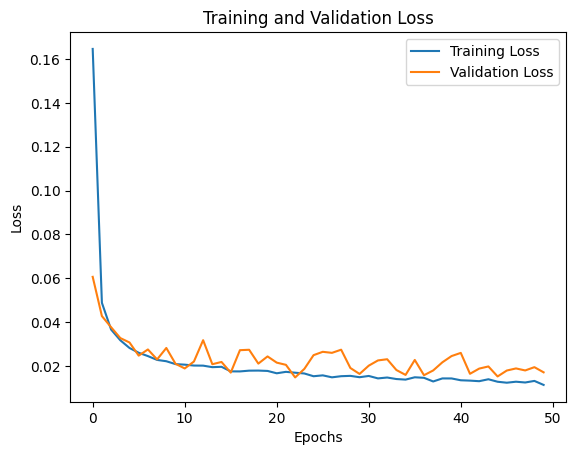

Model saved as mood_prediction_model.pth


In [15]:
# **Step 4: Save and Plot Loss**
plt.plot(training_loss, label="Training Loss")
plt.plot(validation_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.savefig("training_validation_loss.png")
plt.show()

torch.save(model.state_dict(), 'mood_prediction_model.pth')
print("Model saved as mood_prediction_model.pth")

In [16]:
# **Step 5: Evaluate the Model**
model.eval()
y_true = []
y_pred = []

In [17]:
with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model(X_batch)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(y_batch.numpy())
        y_pred.extend(predicted.numpy())

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

              precision    recall  f1-score   support

        calm       0.99      1.00      1.00     11142
   energetic       0.99      1.00      1.00      4575
       happy       0.99      0.99      0.99      3259
         sad       1.00      0.99      0.99      3824

    accuracy                           0.99     22800
   macro avg       0.99      0.99      0.99     22800
weighted avg       0.99      0.99      0.99     22800



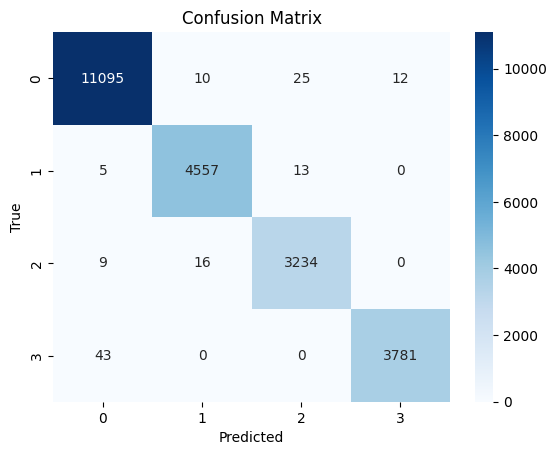

In [19]:
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig("confusion_matrix.png")
plt.show()